In [3]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense, Dropout
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.metrics import Precision, Recall
from sklearn.metrics import f1_score

train_data = pd.read_csv('../data/balanced_train.csv')
test_data = pd.read_csv('../data/balanced_test.csv')

genre_columns = train_data.columns.drop(['Name', 'Description Tokenized'])

# Tokenizar os textos
tokenizer = Tokenizer()
tokenizer.fit_on_texts(list(train_data['Description Tokenized']) + list(test_data['Description Tokenized']))
word_index = tokenizer.word_index
num_words = len(word_index) + 1

X_train = tokenizer.texts_to_sequences(train_data['Description Tokenized'])
X_test = tokenizer.texts_to_sequences(test_data['Description Tokenized'])

maxlen = max(max([len(sequence) for sequence in X_train]), max([len(sequence) for sequence in X_test]))

# Padronizar os textos
X_train = pad_sequences(X_train, maxlen=maxlen)
X_test = pad_sequences(X_test, maxlen=maxlen)

#labels one-hot encoded
y_train = train_data[genre_columns].values
y_test = test_data[genre_columns].values
# Crie o modelo RNN simples com uma camada GRU
embedding_dim = 100

model = Sequential()
model.add(Embedding(num_words, embedding_dim, input_length=maxlen))
model.add(GRU(128, dropout=0.5, recurrent_dropout=0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(genre_columns), activation='sigmoid'))

# Compile e treine o modelo
optimizer = RMSprop(learning_rate=0.01)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=[Precision(), Recall()])

num_epochs = 15
history = model.fit(X_train, y_train, epochs=num_epochs, validation_data=(X_test, y_test), verbose=2)


Epoch 1/15
160/160 - 17s - loss: 0.5554 - precision: 0.5073 - recall: 0.1310 - val_loss: 0.5125 - val_precision: 0.6323 - val_recall: 0.2514 - 17s/epoch - 109ms/step
Epoch 2/15
160/160 - 15s - loss: 0.4760 - precision: 0.6263 - recall: 0.3932 - val_loss: 0.4558 - val_precision: 0.6828 - val_recall: 0.4037 - 15s/epoch - 91ms/step
Epoch 3/15
160/160 - 16s - loss: 0.3859 - precision: 0.7143 - recall: 0.5947 - val_loss: 0.4037 - val_precision: 0.7016 - val_recall: 0.5172 - 16s/epoch - 99ms/step
Epoch 4/15
160/160 - 20s - loss: 0.3165 - precision: 0.7671 - recall: 0.6975 - val_loss: 0.3894 - val_precision: 0.6955 - val_recall: 0.6364 - 20s/epoch - 123ms/step
Epoch 5/15
160/160 - 18s - loss: 0.2675 - precision: 0.8071 - recall: 0.7614 - val_loss: 0.3644 - val_precision: 0.7305 - val_recall: 0.6650 - 18s/epoch - 115ms/step
Epoch 6/15
160/160 - 16s - loss: 0.2196 - precision: 0.8449 - recall: 0.8094 - val_loss: 0.3894 - val_precision: 0.7251 - val_recall: 0.6868 - 16s/epoch - 100ms/step
Epoch 

In [4]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_test)
y_pred_binarized = np.round(y_pred)


report = classification_report(y_test, y_pred_binarized, target_names=genre_columns, zero_division=0)
print(report)

40/40 [==============================] - 4s 17ms/step
                         precision    recall  f1-score   support

                 Comedy       0.74      0.74      0.74       487
                  Crime       0.82      0.75      0.78       271
                  Drama       0.76      0.82      0.79       613
                Romance       0.74      0.61      0.67       270
   Action and Adventure       0.80      0.76      0.78       463
Documentary and History       0.82      0.56      0.67       172
   Family and Animation       0.82      0.65      0.73       275
     Fantasy and Sci-Fi       0.81      0.71      0.76       259
    Horror and Thriller       0.81      0.59      0.68       309

              micro avg       0.78      0.72      0.75      3119
              macro avg       0.79      0.69      0.73      3119
           weighted avg       0.78      0.72      0.74      3119
            samples avg       0.74      0.70      0.70      3119



In [5]:
from sklearn.metrics import precision_recall_curve, roc_curve, auc

y_pred_prob = model.predict(X_test)

pr_curves = {}
roc_curves = {}
for i, genre in enumerate(genre_columns):
    precision, recall, _ = precision_recall_curve(y_test[:, i], y_pred_prob[:, i])
    fpr, tpr, _ = roc_curve(y_test[:, i], y_pred_prob[:, i])
    pr_curves[genre] = (precision, recall)
    roc_curves[genre] = (fpr, tpr)
    
auc_pr = []
auc_roc = []
for i, genre in enumerate(genre_columns):
    ap = auc(pr_curves[genre][1], pr_curves[genre][0])
    ar = auc(roc_curves[genre][0], roc_curves[genre][1])
    auc_pr.append(ap)
    auc_roc.append(ar)

results = pd.DataFrame({'genre': genre_columns, 'AUC-PR': auc_pr, 'AUC-ROC': auc_roc})
print(results)


40/40 [==============================] - 1s 16ms/step
                     genre    AUC-PR   AUC-ROC
0                   Comedy  0.822205  0.879049
1                    Crime  0.863020  0.941588
2                    Drama  0.868983  0.881238
3                  Romance  0.779615  0.906648
4     Action and Adventure  0.869243  0.906576
5  Documentary and History  0.741432  0.925667
6     Family and Animation  0.827445  0.919787
7       Fantasy and Sci-Fi  0.833623  0.916816
8      Horror and Thriller  0.748022  0.891351


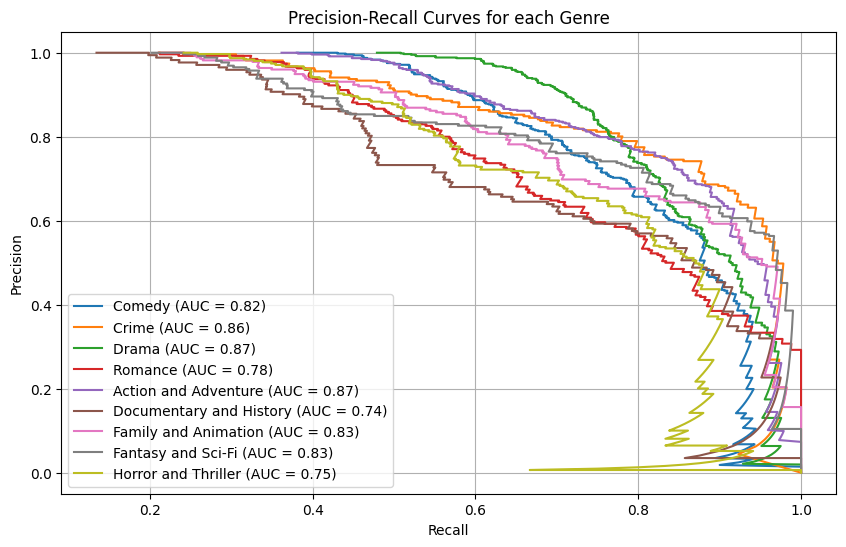

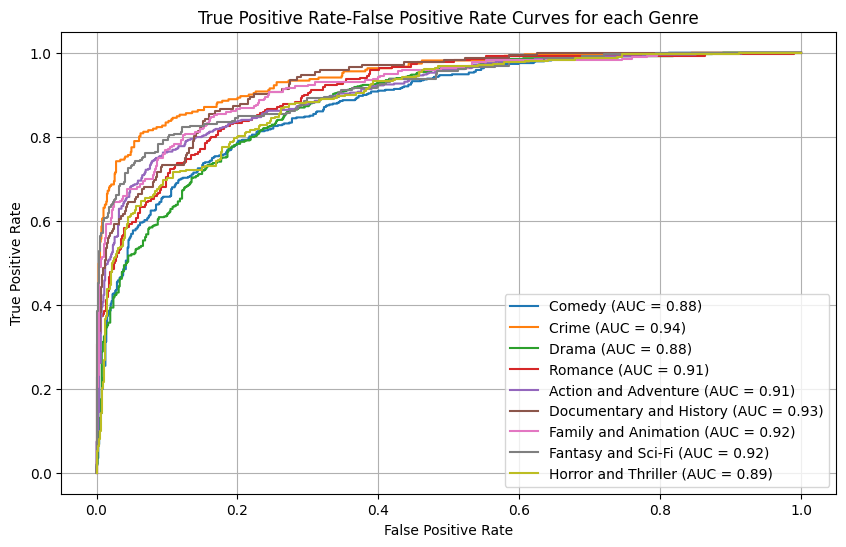

In [7]:
import matplotlib.pyplot as plt

def plot_curves(curves, curve_type, metric_name):
    plt.figure(figsize=(10, 6))
    for genre in curves.keys():
        x, y = curves[genre]
        if metric_name == 'AUC-PR':
            auc_value = auc(y, x)  # Use recall (y) as x and precision (x) as y
        else:
            auc_value = auc(x, y)  # Use FPR (x) as x and TPR (y) as y

        plt.plot(x, y, label=f'{genre} (AUC = {auc_value:.2f})')

    plt.xlabel(curve_type[0])
    plt.ylabel(curve_type[1])
    plt.title(f'{curve_type[1]}-{curve_type[0]} Curves for each Genre')
    plt.legend(loc='best')
    plt.grid()

plot_curves(pr_curves, ('Recall', 'Precision'), 'AUC-PR')
plt.show()

plot_curves(roc_curves, ('False Positive Rate', 'True Positive Rate'), 'AUC-ROC')
plt.show()

In [8]:
from sklearn.metrics import confusion_matrix

# Obter as previsões do modelo
y_pred_binarized = np.round(model.predict(X_test))

# Calcular a matriz de confusão para cada classe
for i, genre in enumerate(genre_columns):
    cm = confusion_matrix(y_test[:, i], y_pred_binarized[:, i])
    print(f'Confusion matrix for {genre}:')
    print(cm)
    print('------------------------')

40/40 [==============================] - 1s 14ms/step
Confusion matrix for Comedy:
[[665 128]
 [125 362]]
------------------------
Confusion matrix for Crime:
[[964  45]
 [ 67 204]]
------------------------
Confusion matrix for Drama:
[[504 163]
 [108 505]]
------------------------
Confusion matrix for Romance:
[[951  59]
 [106 164]]
------------------------
Confusion matrix for Action and Adventure:
[[731  86]
 [109 354]]
------------------------
Confusion matrix for Documentary and History:
[[1087   21]
 [  75   97]]
------------------------
Confusion matrix for Family and Animation:
[[967  38]
 [ 96 179]]
------------------------
Confusion matrix for Fantasy and Sci-Fi:
[[977  44]
 [ 74 185]]
------------------------
Confusion matrix for Horror and Thriller:
[[929  42]
 [128 181]]
------------------------
